In [26]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

In [27]:
def stabilize_video(frames):
    stabilized = []
    prev_gray = cv2.cvtColor(frames[0], cv2.COLOR_BGR2GRAY)
    transforms = []

    for i in range(1, len(frames)):
        curr_gray = cv2.cvtColor(frames[i], cv2.COLOR_BGR2GRAY)
        flow = cv2.calcOpticalFlowFarneback(prev_gray, curr_gray,
                                            None, 0.5, 3, 15, 3, 5, 1.2, 0)
        dx = np.mean(flow[..., 0])
        dy = np.mean(flow[..., 1])
        transforms.append((dx, dy))
        prev_gray = curr_gray

    cumulative_dx, cumulative_dy = 0, 0
    for i, frame in enumerate(frames):
        if i == 0:
            stabilized.append(frame)
            continue
        cumulative_dx += transforms[i - 1][0]
        cumulative_dy += transforms[i - 1][1]

        trans_mat = np.float32([[1, 0, -cumulative_dx],
                                [0, 1, -cumulative_dy]])
        stabilized_frame = cv2.warpAffine(frame, trans_mat, (frame.shape[1], frame.shape[0]))
        stabilized.append(stabilized_frame)

    return stabilized


In [ ]:
def detect_motion_roi(frames, threshold=15, min_area=500):
    motion_accum = None
    for i in range(1, len(frames)):
        gray1 = cv2.cvtColor(frames[i - 1], cv2.COLOR_BGR2GRAY)
        gray2 = cv2.cvtColor(frames[i], cv2.COLOR_BGR2GRAY)
        diff = cv2.absdiff(gray1, gray2)
        _, thresh = cv2.threshold(diff, threshold, 255, cv2.THRESH_BINARY)
        motion_accum = thresh if motion_accum is None else cv2.bitwise_or(motion_accum, thresh)
    contours, _ = cv2.findContours(motion_accum, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None
    x_min, y_min, x_max, y_max = float('inf'), float('inf'), 0, 0
    for c in contours:
        if cv2.contourArea(c) < min_area:
            continue
        x, y, w, h = cv2.boundingRect(c)
        x_min = min(x_min, x)
        y_min = min(y_min, y)
        x_max = max(x_max, x + w)
        y_max = max(y_max, y + h)

    return (x_min, y_min, x_max - x_min, y_max - y_min)


In [29]:

def preview_roi(frames, roi_box, num_samples=5):
    if not roi_box:
        print("No ROI detected.")
        return

    x, y, w, h = roi_box
    step = max(1, len(frames) // num_samples)
    for i in range(0, len(frames), step):
        frame = frames[i].copy()
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 3)
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.title(f"Frame {i} with ROI")
        plt.axis('off')
        plt.show()
        if i + step >= len(frames):
            break


In [30]:

def save_preprocessed_frames(frames, roi_box, output_dir, equalize_hist=True):
    os.makedirs(output_dir, exist_ok=True)
    x, y, w, h = roi_box
    for idx, frame in enumerate(frames):
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        if equalize_hist:
            gray = cv2.equalizeHist(gray)
        cropped = gray[y:y+h, x:x+w]
        cv2.imwrite(os.path.join(output_dir, f"frame_{idx:04d}.png"), cropped)


In [31]:
def preprocess_video(video_path, output_dir):
    cap = cv2.VideoCapture(video_path)
    frames = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()

    print(f"[INFO] Loaded {len(frames)} frames.")

    stabilized_frames = stabilize_video(frames)
    print("[INFO] Video stabilized.")

    roi = detect_motion_roi(stabilized_frames)
    if roi:
        print(f"[INFO] Detected ROI: {roi}")
    else:
        print("[WARNING] No motion ROI detected!")
        return

    preview_roi(stabilized_frames, roi)
    save_preprocessed_frames(stabilized_frames, roi, output_dir)
    print(f"[INFO] Preprocessed frames saved to {output_dir}")


Unbalanced Weight-front:
[INFO] Loaded 2084 frames.
[INFO] Video stabilized.
[INFO] Detected ROI: (0, 203, 325, 132)


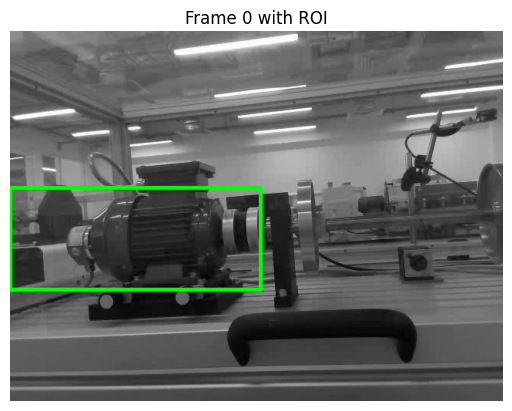

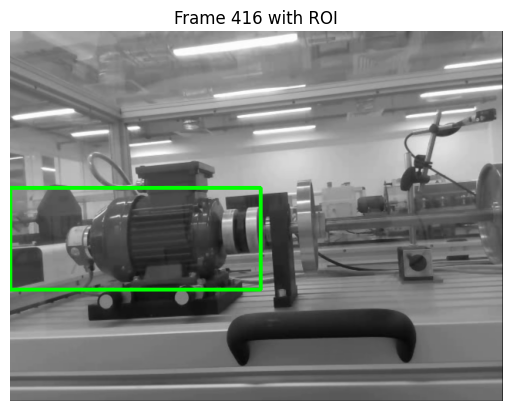

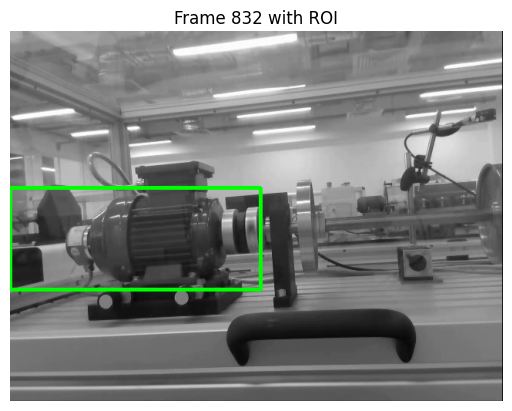

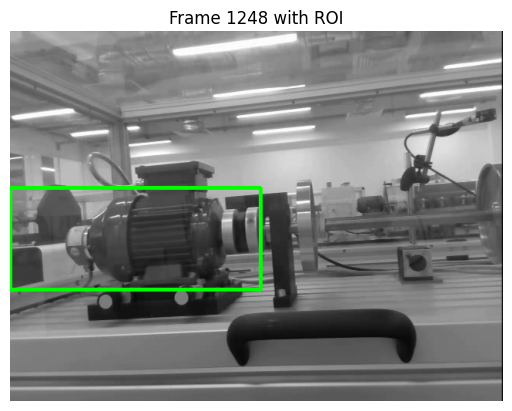

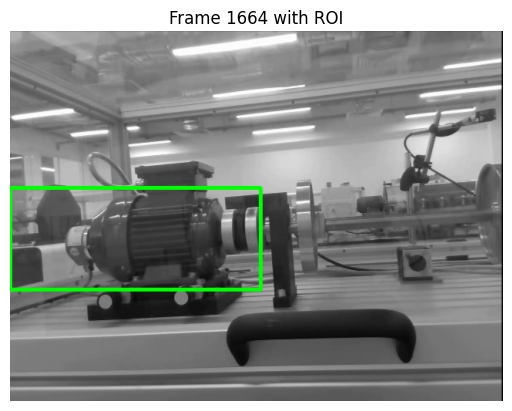

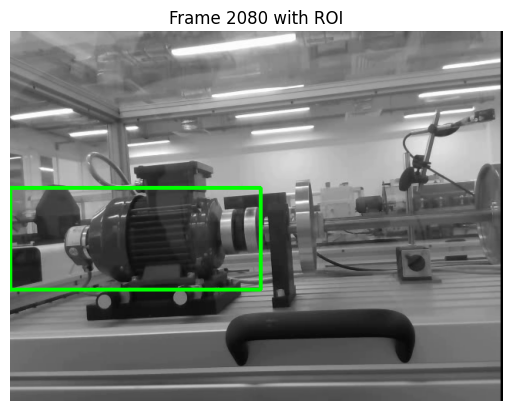

[INFO] Preprocessed frames saved to preprocessed_data/Unbalance_weight/front
Unbalanced Weight-angle:
[INFO] Loaded 2819 frames.
[INFO] Video stabilized.
[INFO] Detected ROI: (0, 0, 640, 480)


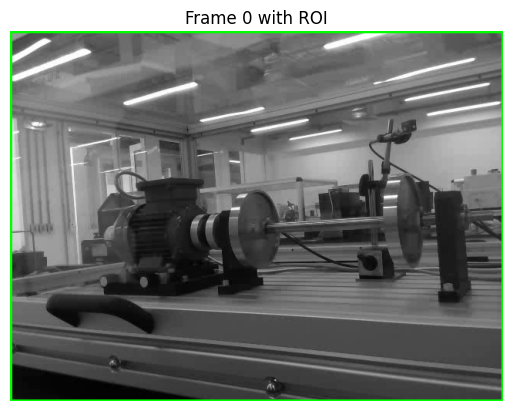

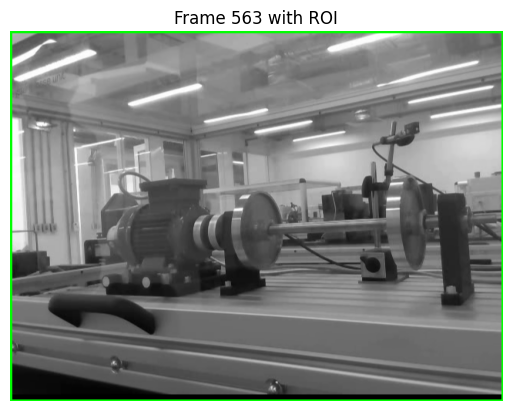

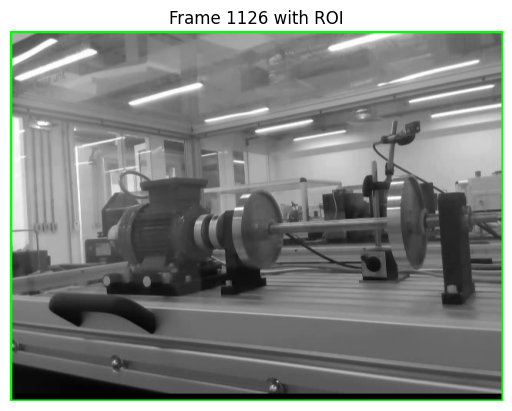

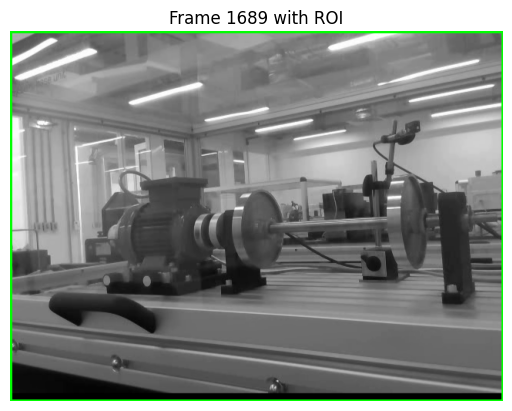

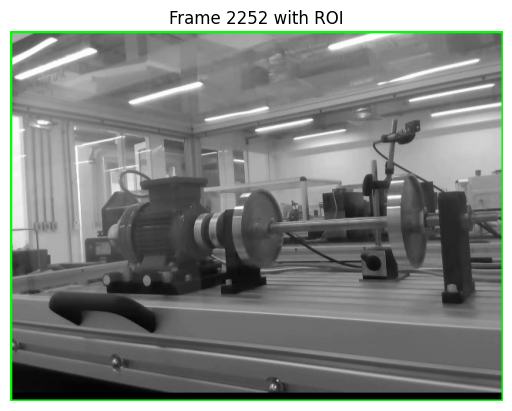

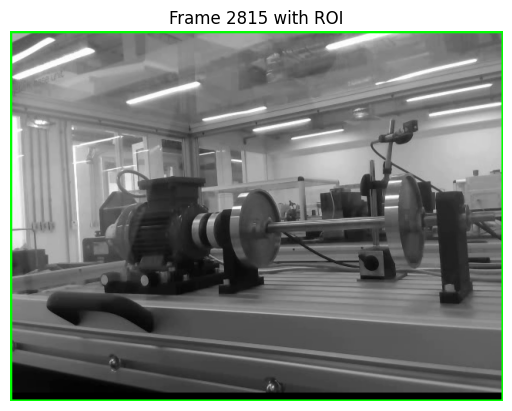

[INFO] Preprocessed frames saved to preprocessed_data/Unbalance_weight/angle
Bearing fault-front:
[INFO] Loaded 1717 frames.
[INFO] Video stabilized.
[INFO] Detected ROI: (155, 20, 485, 284)


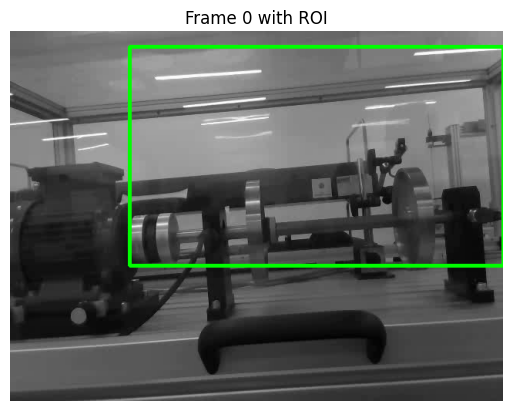

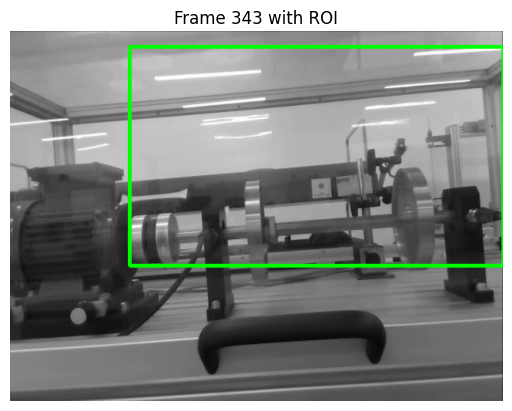

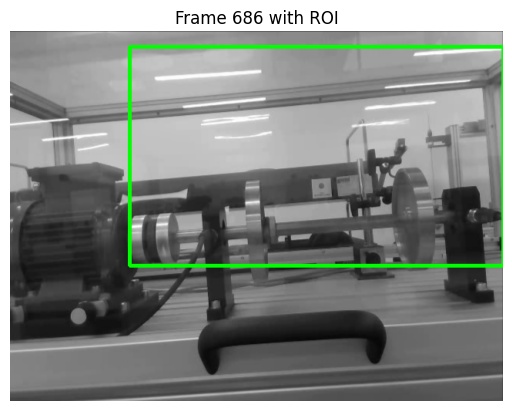

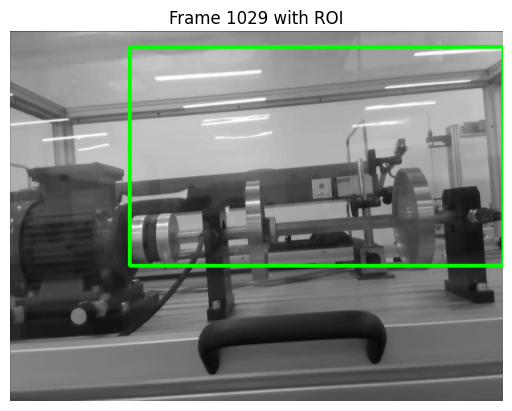

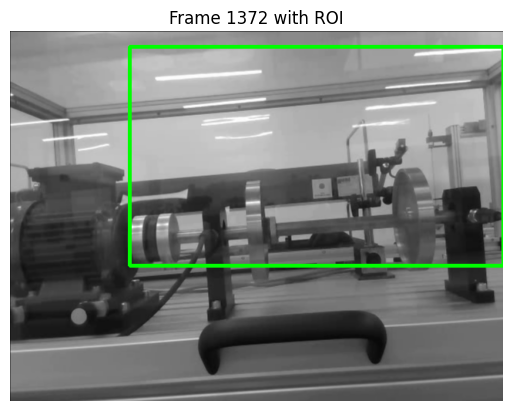

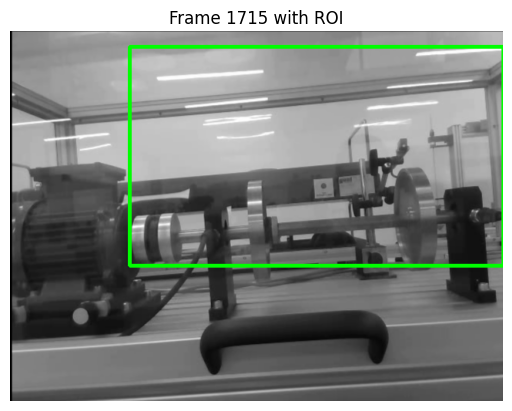

[INFO] Preprocessed frames saved to preprocessed_data/Bearing_fault/front
Bearing fault-angle:
[INFO] Loaded 1620 frames.
[INFO] Video stabilized.
[INFO] Detected ROI: (158, 163, 191, 123)


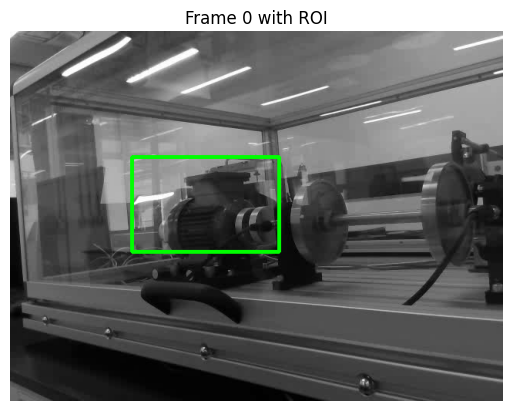

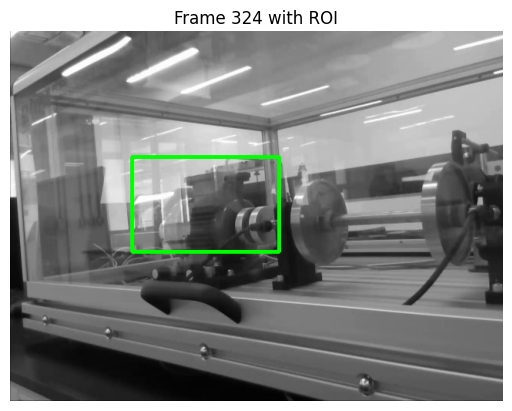

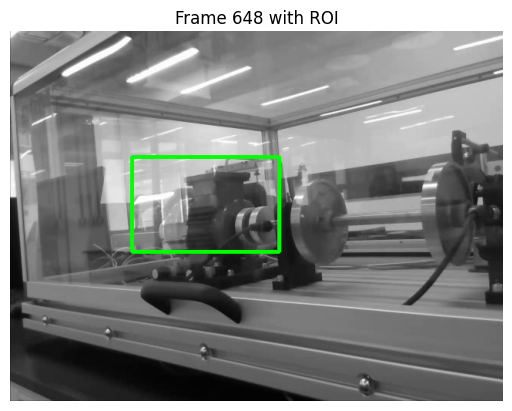

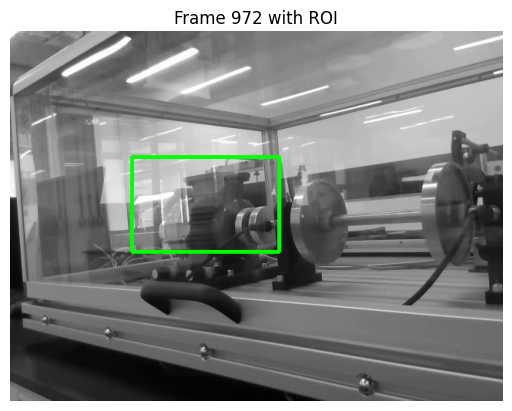

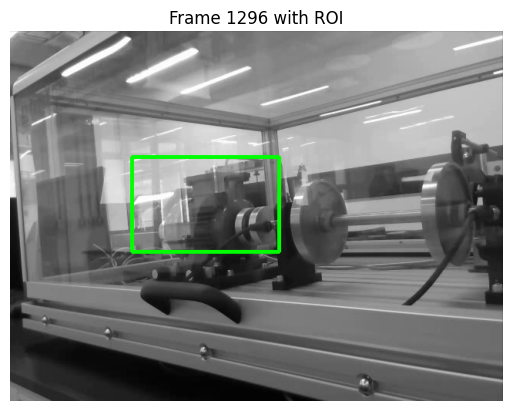

[INFO] Preprocessed frames saved to preprocessed_data/Bearing_fault/angle
Normal state-front:
[INFO] Loaded 1884 frames.
[INFO] Video stabilized.
[INFO] Detected ROI: (17, 8, 290, 295)


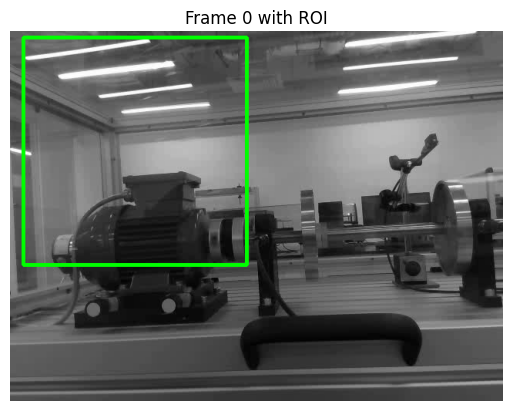

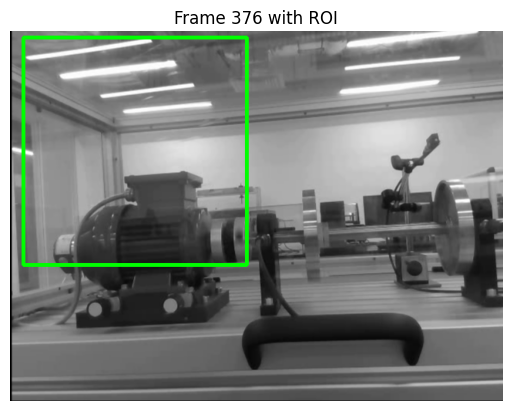

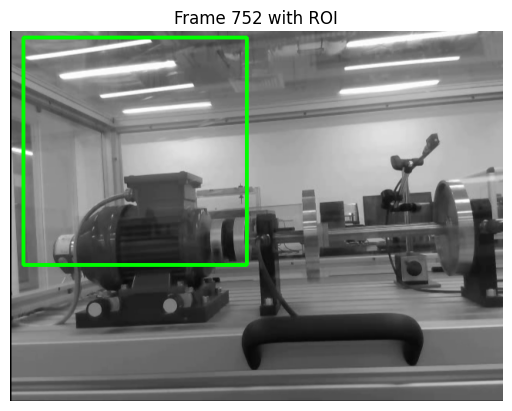

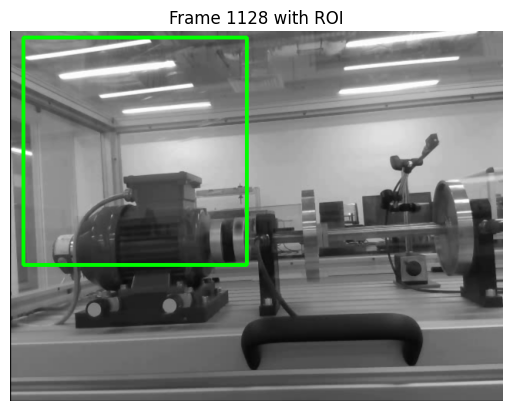

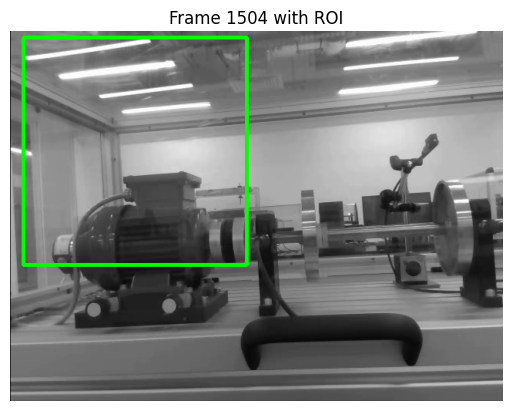

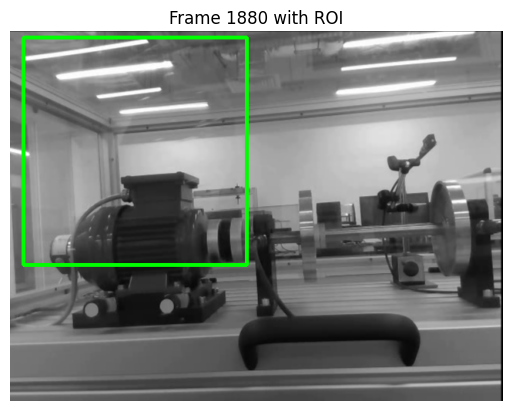

[INFO] Preprocessed frames saved to preprocessed_data/Normal_state/front
Normal state-angle:
[INFO] Loaded 1909 frames.
[INFO] Video stabilized.
[INFO] Detected ROI: (25, 138, 517, 199)


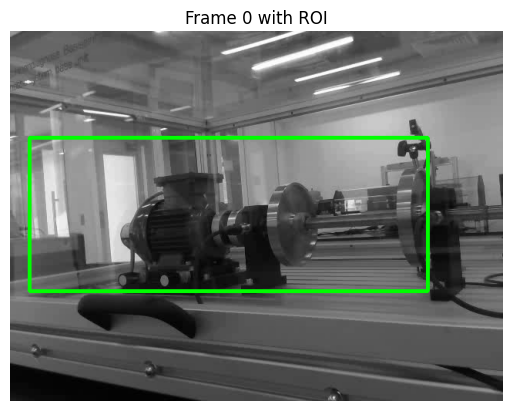

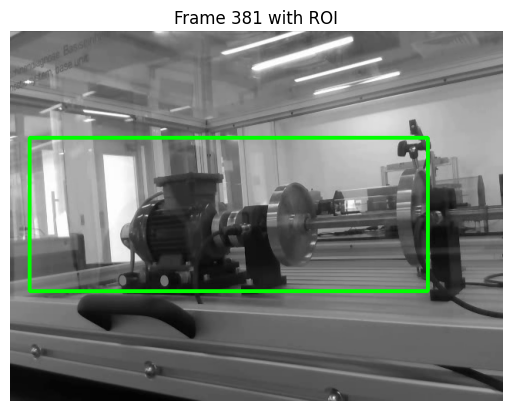

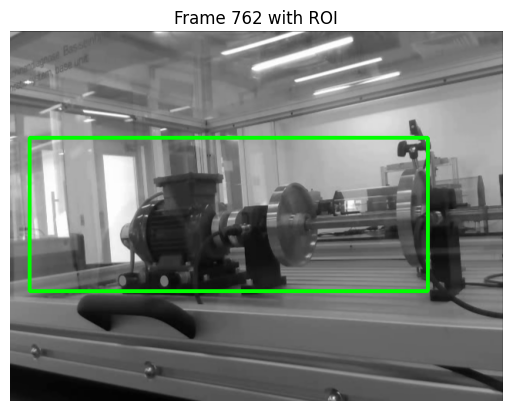

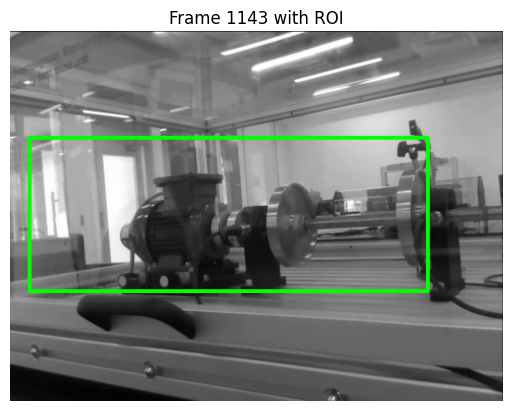

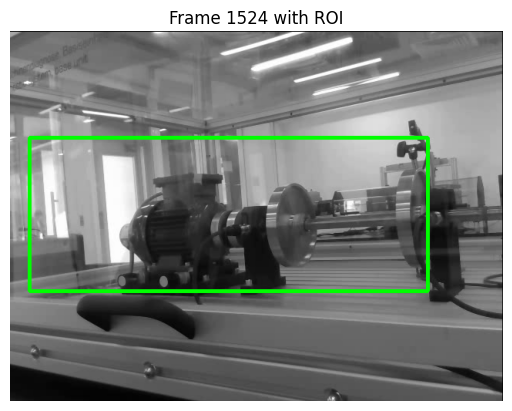

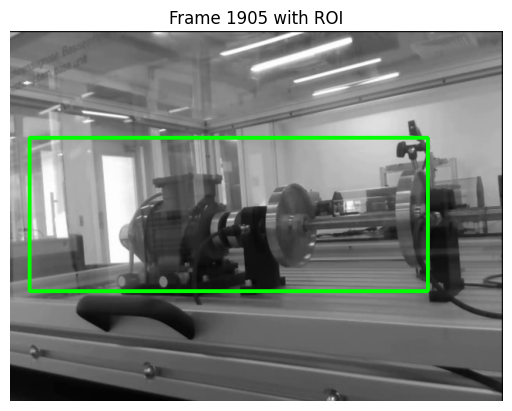

[INFO] Preprocessed frames saved to preprocessed_data/Normal_state/angle


In [ ]:
# Example usage
print("Unbalanced Weight-front:")
video_path = "input_data/Unbalance_weight/front.avi"
output_dir = "preprocessed_data/Unbalance_weight/front"
preprocess_video(video_path, output_dir)
#--------------------------------------------------
print("Unbalanced Weight-angle:")
video_path = "input_data/Unbalance_weight/angle.avi"
output_dir = "preprocessed_data/Unbalance_weight/angle"
preprocess_video(video_path, output_dir)
#--------------------------------------------------
print("Bearing fault-front:")
video_path = "input_data/Bearing_fault/front.avi"
output_dir = "preprocessed_data/Bearing_fault/front"
preprocess_video(video_path, output_dir)
#--------------------------------------------------
print("Bearing fault-angle:")
video_path = "input_data/Bearing_fault/angle.avi"
output_dir = "preprocessed_data/Bearing_fault/angle"
preprocess_video(video_path, output_dir)
#--------------------------------------------------
print("Normal state-front:")
video_path = "input_data/Normal_state/front.avi"
output_dir = "preprocessed_data/Normal_state/front"
preprocess_video(video_path, output_dir)
#--------------------------------------------------
print("Normal state-angle:")
video_path = "input_data/Normal_state/angle.avi"
output_dir = "preprocessed_data/Normal_state/angle"
preprocess_video(video_path, output_dir)
